In [56]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

In [57]:
def getLocation(t):
    fields = ['entities', 'user', 'place', 'coordinates']
    for field in fields:
        if(pd.isna(t[field]) or t[field].isnumeric() or (t[field] == 'True' or t[field] == 'False')):
            t[field] = dict()
        else:
            t[field] = eval(t[field])
    
    location = resolver.resolve_tweet(t)
    return location


def getCountry(t):
    loc = getLocation(t)
    if(loc):
        return loc[1].country
    return None

In [58]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
retweet_dir = main_dir + 'data_retweets/'
locations_dir = retweet_dir + 'locations/'

text_list = []
retweet_files = (file for file in os.listdir(retweet_dir) if os.path.isfile(os.path.join(retweet_dir, file)))

for file in sorted(retweet_files):
    print('Reading... ' + file)
    df = pd.read_csv(retweet_dir + file)
    print(str(len(df)) + ' Tweets!')
#     print("Extracting locations .. .  .")
    
#     df['country'] = df.apply(getCountry, axis = 1)
    df_text = df[['created_at', 'full_text', 'entities', 'user', 'place', 'coordinates']]
    
    text_list.append(df_text)
    print(file + ' processing done!')
    print()



Reading... 05-20-2020.csv
618997 Tweets!
05-20-2020.csv processing done!

Reading... 05-21-2020.csv
578771 Tweets!
05-21-2020.csv processing done!

Reading... 05-22-2020.csv
551356 Tweets!
05-22-2020.csv processing done!

Reading... 05-23-2020.csv
408986 Tweets!
05-23-2020.csv processing done!

Reading... 05-24-2020.csv
420865 Tweets!
05-24-2020.csv processing done!

Reading... 05-25-2020.csv
468422 Tweets!
05-25-2020.csv processing done!

Reading... 05-26-2020.csv
530600 Tweets!
05-26-2020.csv processing done!

Reading... 05-27-2020.csv
509952 Tweets!
05-27-2020.csv processing done!

Reading... 05-28-2020.csv
554402 Tweets!
05-28-2020.csv processing done!

Reading... 05-29-2020.csv
472344 Tweets!
05-29-2020.csv processing done!



In [ ]:
df_text = pd.concat(text_list).drop_duplicates().reset_index(drop = True)
df_text['date'] = pd.to_datetime(df_text.created_at).apply(lambda x: x.strftime("%Y-%m-%d"))
df_text = df_text[df_text.date >= '2020-05-20']
df_text['country'] = df_text.apply(getCountry, axis = 1)
df_text.drop(['user', 'place', 'coordinates'], axis = 1, inplace = True)

df_text.head()

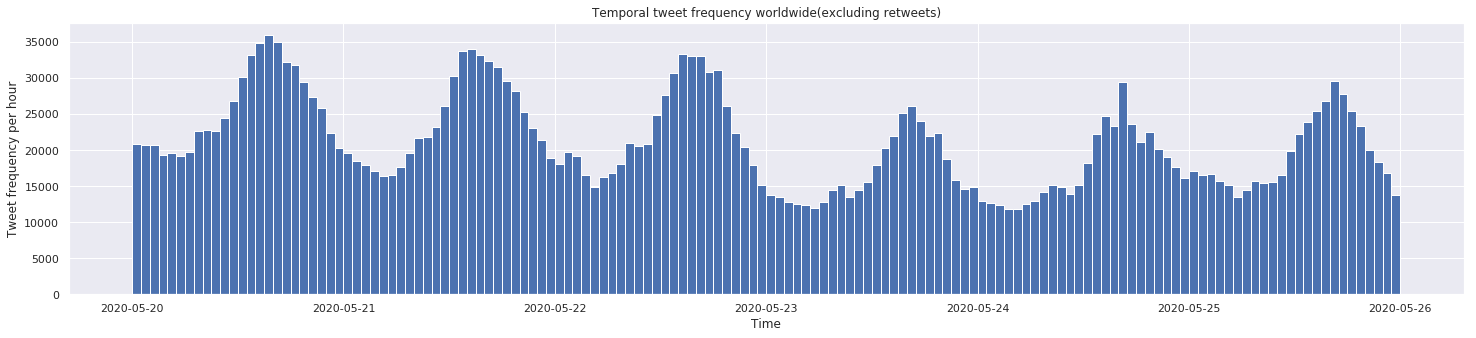

In [273]:
fig = plt.figure(figsize=(25,5))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide(excluding retweets)', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df_text.created_at), bins = 24*len(text_list))
plt.show()

In [340]:
def cleanForVader(tweet):
    text = tweet.full_text
    
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
        
    text = re.sub('RT|cc', '', text)  # remove RT and cc
    text = re.sub('#', '', text)  # remove hashtag symbol
    text = re.sub('@\S+', '', text) # remove @mentions
    text = re.sub('\S+&\S+', '', text) # remove &amps and other symbols
    text = re.sub('&\S+', '', text) # remove &amps and other symbols
    text = re.sub(r'‚Ä¶', '', text)
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    return text.strip()

def cleanText(tweet, stem = False):
    text = cleanForVader(tweet)
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+',' ', text) # remove non ASCII characters
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  # remove punctuations
    
    t_list = []
    stop_words = set(stopwords.words('english'))
    stop_words.update(['coronavirusoutbreak', 'coronavirusPandemic', 'covid_19', 'epitwitter', 'ihavecorona', 'amp', 'coronavirus', 'covid19', 'covid-19', 'covid__19'])
    t_list = text.split()
    t_list = [word for word in t_list if word not in stop_words]
    
    if stem:
        stemmer = SnowballStemmer('english')
        t_list = [stemmer.stem(t) for t in t_list]

    return ' '.join(t_list)

In [275]:
sid = SentimentIntensityAnalyzer()
df_text['vader_score'] = df_text.apply(lambda x: sid.polarity_scores(cleanForVader(x))['compound'], axis = 1)
df_text['sentiment'] = df_text.vader_score.apply(lambda x: 'positive' if x > 0.4 else ('negative' if x < -0.4 else 'neutral'))
df_text.head()

,created_at,full_text,entities,country,date,vader_score,sentiment
0,Thu May 21 00:00:01 +0000 2020,RT @latoyajackson: I’m ready for this!\n#Wedne...,"{'hashtags': [{'text': 'WednesdayThoughts', 'i...",None,2020-05-21,0.4199,positive
1,Thu May 21 00:00:01 +0000 2020,We know this is a tough financial time for man...,"{'hashtags': [{'text': 'COVID19', 'indices': [...",None,2020-05-21,-0.1779,neutral
2,Thu May 21 00:00:00 +0000 2020,How the COVID “Experts” Got Everything Wrong! ...,"{'hashtags': [{'text': 'Covid_19', 'indices': ...",United States,2020-05-21,-0.1342,neutral
3,Thu May 21 00:00:00 +0000 2020,We are LIVE for our #TLCtransform chat on Pivo...,"{'hashtags': [{'text': 'TLCtransform', 'indice...",United States,2020-05-21,0.4588,positive
4,Thu May 21 00:00:00 +0000 2020,RT @FLOTUS: Productive call today with our Sta...,"{'hashtags': [{'text': 'COVID19', 'indices': [...",None,2020-05-21,0.0772,neutral


In [276]:
codes_df = pd.read_csv('country_codes.csv')
df_text = pd.merge(df_text, codes_df, on = 'country', how = 'left')
df_text.drop(['country'], axis = 1, inplace = True)
df_text.tail()

,created_at,full_text,entities,date,vader_score,sentiment,code
3030506,Mon May 25 00:00:01 +0000 2020,"RT @sticksnet: In 2 or 3 weeks, when the DEATH...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-25,-0.8122,negative,USA
3030507,Mon May 25 00:00:01 +0000 2020,RT @beekks1: 🧩$120🧩until🚀deadline June 14!\n#K...,"{'hashtags': [{'text': 'Kids', 'indices': [43,...",2020-05-25,0.4003,positive,NaN
3030508,Mon May 25 00:00:01 +0000 2020,Big #MemorialDayWeekend crowds at beaches and ...,"{'hashtags': [{'text': 'MemorialDayWeekend', '...",2020-05-25,-0.6369,negative,USA
3030509,Mon May 25 00:00:01 +0000 2020,"""Change is our one constant. I long for my onc...","{'hashtags': [{'text': 'gynecologiccancer', 'i...",2020-05-25,0.4939,positive,NaN
3030510,Mon May 25 00:00:00 +0000 2020,As businesses look at transitioning to working...,"{'hashtags': [{'text': 'coronavirus', 'indices...",2020-05-25,0.4404,positive,AUS


In [277]:
df_text.code.value_counts()

USA    608912
IND    203695
GBR    194833
CAN     89901
NGA     37512
AUS     28241
ZAF     27035
PAK     22506
IRL     20186
KEN     16369
FRA     10948
HKG     10146
UGA      8641
DEU      8031
PHL      6665
ARE      6270
GHA      6218
CHE      6193
BEL      5438
MYS      5132
ESP      5072
IDN      4914
LKA      4005
NLD      3802
JPN      3765
ITA      3565
BRA      3558
THA      3445
SGP      3114
ARG      2580
        ...  
DJI        77
KGZ        76
AGO        70
MDA        61
SUR        57
UZB        53
GRL        51
BRN        48
BEN        45
TJK        44
WSM        42
SYC        40
AND        31
TKM        30
VAT        29
HRV        29
DMA        28
ATG        27
MTQ        23
ERI        22
TCA        16
GRD        16
ABW        15
VGB        13
PYF        10
CXR         5
REU         5
SGS         2
KNA         2
VCT         2
Name: code, Length: 171, dtype: int64

In [278]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic", "covid__19"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

In [279]:
df_text['hashtags'] = df_text.entities.apply(getHashtags)
df_text.tail()

,created_at,full_text,entities,date,vader_score,sentiment,code,hashtags
3030506,Mon May 25 00:00:01 +0000 2020,"RT @sticksnet: In 2 or 3 weeks, when the DEATH...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-25,-0.8122,negative,USA,[]
3030507,Mon May 25 00:00:01 +0000 2020,RT @beekks1: 🧩$120🧩until🚀deadline June 14!\n#K...,"{'hashtags': [{'text': 'Kids', 'indices': [43,...",2020-05-25,0.4003,positive,NaN,"[Kids, play, organization, prek, classroom, st..."
3030508,Mon May 25 00:00:01 +0000 2020,Big #MemorialDayWeekend crowds at beaches and ...,"{'hashtags': [{'text': 'MemorialDayWeekend', '...",2020-05-25,-0.6369,negative,USA,"[MemorialDayWeekend, MemorialDay]"
3030509,Mon May 25 00:00:01 +0000 2020,"""Change is our one constant. I long for my onc...","{'hashtags': [{'text': 'gynecologiccancer', 'i...",2020-05-25,0.4939,positive,NaN,"[gynecologiccancer, ASCODailyNews, gyncsm]"
3030510,Mon May 25 00:00:00 +0000 2020,As businesses look at transitioning to working...,"{'hashtags': [{'text': 'coronavirus', 'indices...",2020-05-25,0.4404,positive,AUS,"[healthyworkplaces, workplaceenvironment]"


In [280]:
def getTermFrequency(tweets, count):
    tweet_series = tweets.apply(cleanText, axis = 1)
    tweet_list = [word for tweet in tweet_series for word in tweet.split()]
    counts = Counter(tweet_list).most_common(count)
    counts_df = pd.DataFrame(counts)
    counts_df.columns = ['word', 'frequency']
    return counts_df

In [281]:
def getMovingAverages(df, frac, roll):
    ot = df.sample(frac = frac)
    ot['created_at'] = pd.to_datetime(ot['created_at'])
    ot.index = pd.to_datetime(ot['created_at'])
    ot.sort_index(inplace=True)
    ot['expanding'] = ot['vader_score'].expanding().mean()
    ot['rolling'] = ot['vader_score'].rolling(roll).mean()
    return ot

In [282]:
def getPolarClouds(df, max_words):
    
    positive = df[df['sentiment'] == 'positive'].apply(cleanText, axis = 1)
    negative = df[df['sentiment'] == 'negative'].apply(cleanText, axis = 1)
    neutral = df[df['sentiment'] == 'neutral'].apply(cleanText, axis = 1)
    full = df.apply(cleanText, axis = 1)
    
    positive_list = [word for line in positive for word in line.split()]
    negative_list = [word for line in negative for word in line.split()]
    neutral_list = [word for line in neutral for word in line.split()]
    full_list = [word for line in full for word in line.split()]
    
    positive_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(positive_list))

    negative_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(negative_list))

    neutral_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(neutral_list))
    
    full_cloud = WordCloud(
        background_color='black',
        max_words=max_words,
        max_font_size=40, 
        scale=5,
        random_state=1,
        collocations=False,
#         stopwords=stop_words,
        normalize_plurals=False
    ).generate(' '.join(full_list))

    return {'positive': positive_cloud, 'neutral': neutral_cloud, 'negative': negative_cloud, 'all': full_cloud}

In [283]:
def flattenSeries(s):
    return [w for l in s for w in l]

In [296]:
def displayWordcloud(top_words, title, n_components, max_words):
    fig = plt.figure(figsize = (15, 10))
    fig.tight_layout(pad = 0)
    j = np.ceil(n_components/2)
    word_cloud = WordCloud(
#         background_color='black',
        max_words=max_words,
        max_font_size=50, 
        scale=5,
        random_state=1,
#         collocations=False,
#         normalize_plurals=False
    )
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 2, i).set_title("May " + str(t+20))
#         plt.plot()
        plt.imshow(word_cloud.generate(' '.join(top_words[t])))
        plt.axis("off")
#     fig.suptitle(title)
    plt.show()

In [303]:
def getHashtagCorr(series, min_appearance = 200):
#     print(type(series))
    flat = pd.Series(flattenSeries(series))
#     print(flat.head())
    counts = flat.value_counts()
    counts.sort_index()
    popular_hashtags = counts.reset_index()
    popular_hashtags.columns = ['hashtag', 'counts']
#     print(popular_hashtags.head())
    
    # find popular hashtags - make into python set for efficiency
    popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts.apply(lambda x: x > min_appearance)]['hashtag'])
    
    popular_hashtags_series = series.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
    # drop rows without popular hashtag
    popular_hashtags_series = popular_hashtags_series[popular_hashtags_series.apply(lambda hashtag_list: hashtag_list !=[])]
    
    hashtag_df = pd.DataFrame()
    hashtag_df['hashtags'] = popular_hashtags_series
    
    for hashtag in popular_hashtags_set:
        # make columns to encode presence of hashtags
        hashtag_df['{}'.format(hashtag)] = hashtag_df.hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))

    hashtag_matrix = hashtag_df.drop('hashtags', axis=1)
    return hashtag_matrix.corr()


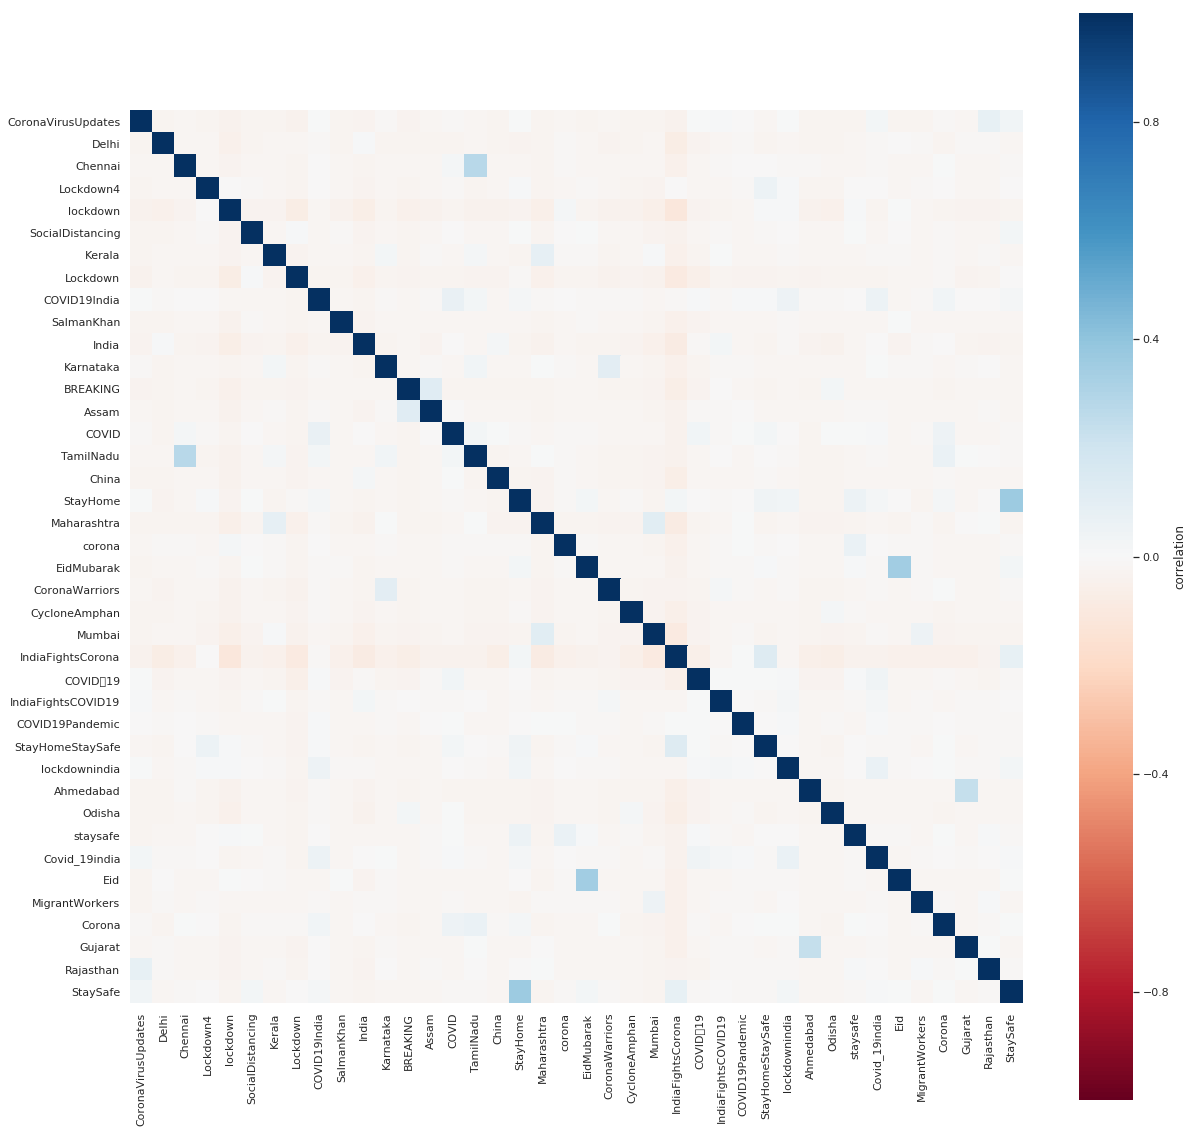

In [314]:
def displayCorr(series, min_appearance = 400):
    plt.figure(figsize = (20, 20))
    correlations = getHashtagCorr(series, min_appearance)
    sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
    plt.show()

displayCorr(df_country['hashtags'], 600)

In [317]:
def displayDailyCorr(df):
    fig = plt.figure(figsize = (20, 30))
    fig.tight_layout()
    j = np.ceil(len(df)/2)
    
    for t in range(len(df)):
        correlations = df.hashtags[t]
        i=t+1
        plt.subplot(j, 2, i).set_title("May " + str(t+20))
        sns.heatmap(correlations, cmap='RdBu', vmin=-1, vmax=1, square = True, cbar_kws={'label':'correlation'})
#     fig.suptitle(title)
    plt.show()
    
# p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
# displayCorr(p)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [357]:
def getTopics(df, n_topics, vectorizer, stem = False):
    df['cleaned_text'] = df.apply(cleanText, args = (stem,), axis = 1)
    
    vectorizer_tf = vectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 100)
    
    # apply transformation
    tf = vectorizer_tf.fit_transform(df['cleaned_text'])
    
    # for TF DTM
    lda_tf = LatentDirichletAllocation(n_components = n_topics, random_state=0)
    lda_tf.fit(tf)
    
    return {'model': lda_tf, 'tf': tf, 'vectorizer': vectorizer_tf}
    

country = 'GBR'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]
# getTopics(df_country, 10, 20)
topics = getTopics(df_country, 20, CountVectorizer)
vis = pyLDAvis.sklearn.prepare(topics['model'], topics['tf'], topics['vectorizer']) 
pyLDAvis.save_html(vis, 'UK_topics.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.143925 -0.059279       1        1  7.518039
5      0.116110  0.194671       2        1  7.454057
19    -0.172261 -0.127457       3        1  7.204506
9     -0.169316  0.029777       4        1  5.750361
12    -0.139166  0.039118       5        1  5.698342
7      0.033861 -0.006344       6        1  5.486780
14    -0.089154 -0.131544       7        1  5.253073
15    -0.069419  0.041132       8        1  5.171343
8     -0.130011  0.091816       9        1  4.989352
10     0.012689  0.024981      10        1  4.931475
18     0.000755  0.062710      11        1  4.689242
3      0.022977 -0.099422      12        1  4.641604
0     -0.114503 -0.037835      13        1  4.574356
11     0.019639  0.191969      14        1  4.571710
13     0.111168  0.049956      15        1  4.076689
6      0.121845  0.031645      16        1  4.041390
4      0.038235  0.090222      17        1  3.645210
1      0.225873 -0.247455      18        1  3.559975
16     0.089362 -0.206646      19        1  3.405731
2      0.235240  0.067985      20        1  3.336765, topic_info=     Category          Freq         Term         Total  loglift  logprob
623   Default  14251.000000     cummings  14251.000000  30.0000  30.0000
2572  Default   6484.000000      support   6484.000000  29.0000  29.0000
1244  Default   6259.000000         home   6259.000000  28.0000  28.0000
1198  Default   6160.000000       health   6160.000000  27.0000  27.0000
2671  Default   3729.000000        times   3729.000000  26.0000  26.0000
1210  Default   6556.000000         help   6556.000000  25.0000  25.0000
1561  Default  12237.000000     lockdown  12237.000000  24.0000  24.0000
352   Default   6518.000000         care   6518.000000  23.0000  23.0000
2653  Default   3032.000000        thing   3032.000000  22.0000  22.0000
1572  Default   3503.000000         look   3503.000000  21.0000  21.0000
2524  Default   3537.000000        story   3537.000000  20.0000  20.0000
609   Default   6960.000000       crisis   6960.000000  19.0000  19.0000
657   Default   4983.000000          day   4983.000000  18.0000  18.0000
2930  Default   4420.000000      workers   4420.000000  17.0000  17.0000
667   Default   7013.000000       deaths   7013.000000  16.0000  16.0000
2392  Default   2765.000000         sick   2765.000000  15.0000  15.0000
365   Default   3662.000000        cases   3662.000000  14.0000  14.0000
983   Default   2663.000000     families   2663.000000  13.0000  13.0000
1140  Default   3606.000000         govt   3606.000000  12.0000  12.0000
1750  Default   5589.000000          nhs   5589.000000  11.0000  11.0000
1746  Default  11032.000000          new  11032.000000  10.0000  10.0000
1880  Default  17850.000000       people  17850.000000   9.0000   9.0000
773   Default   5655.000000      dominic   5655.000000   8.0000   8.0000
415   Default   2934.000000     children   2934.000000   7.0000   7.0000
1868  Default   4474.000000     patients   4474.000000   6.0000   6.0000
2600  Default   4027.000000     symptoms   4027.000000   5.0000   5.0000
2223  Default   2228.000000       review   2228.000000   4.0000   4.0000
2565  Default   2223.000000       sunday   2223.000000   3.0000   3.0000
975   Default   2213.000000      failure   2213.000000   2.0000   2.0000
280   Default   4683.000000        boris   4683.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
1243  Topic20    167.187468         holy    168.139926   3.3945  -5.7224
844   Topic20    154.493703    eidalfitr    155.446161   3.3940  -5.8014
173   Topic20    142.857751    ausations    143.810209   3.3935  -5.8797
72    Topic20    138.626496       alfitr    139.578954   3.3933  -5.9098
1966  Topic20    138.626496       prayer    139.578954   3.3933  -5.9098
1222  Topic20    131.221800       hiding    132.174258   3.3929  -5.9646
39    Topic20    

In [349]:
pyLDAvis.save_html(pyLDAvis.sklearn.prepare(topics['model'], topics['tf'], topics['vectorizer']), 'india_topics.html')

## Filter by country

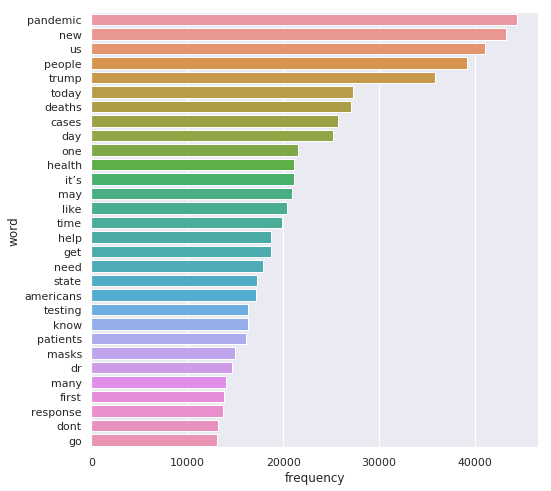

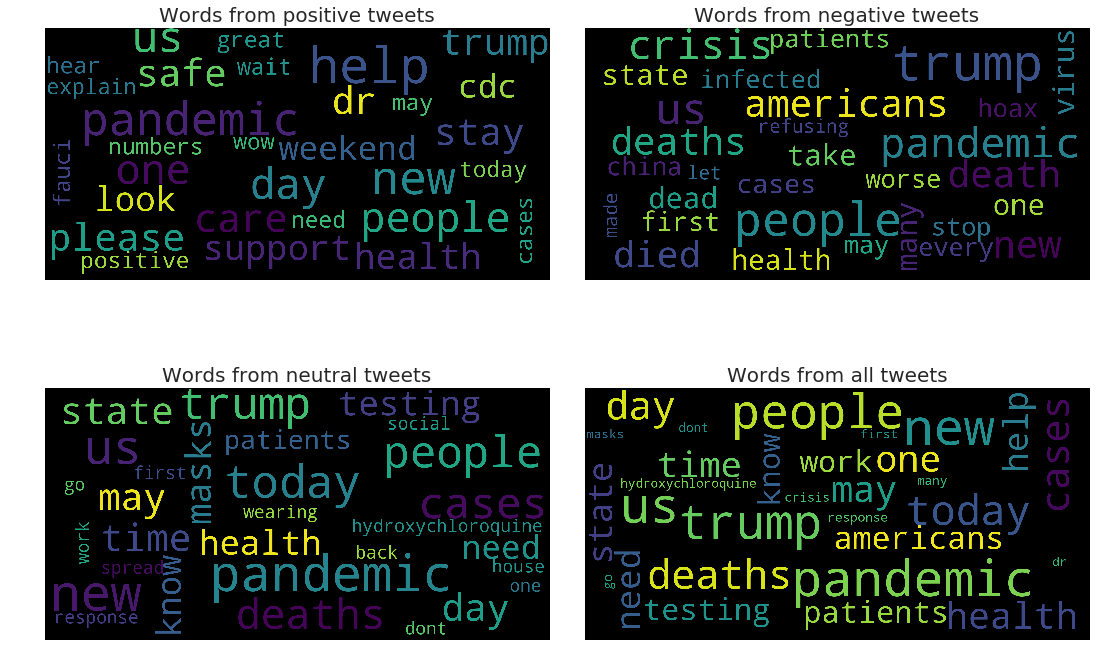

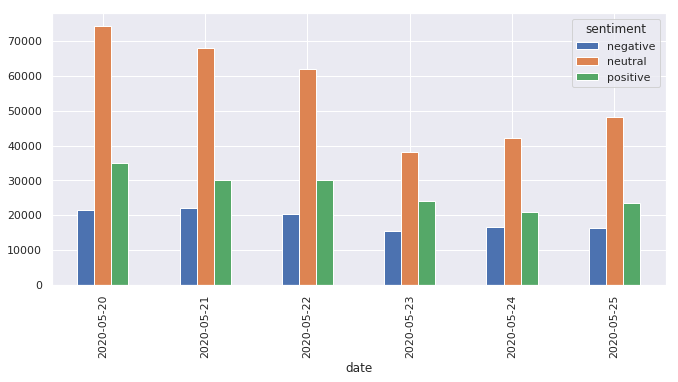

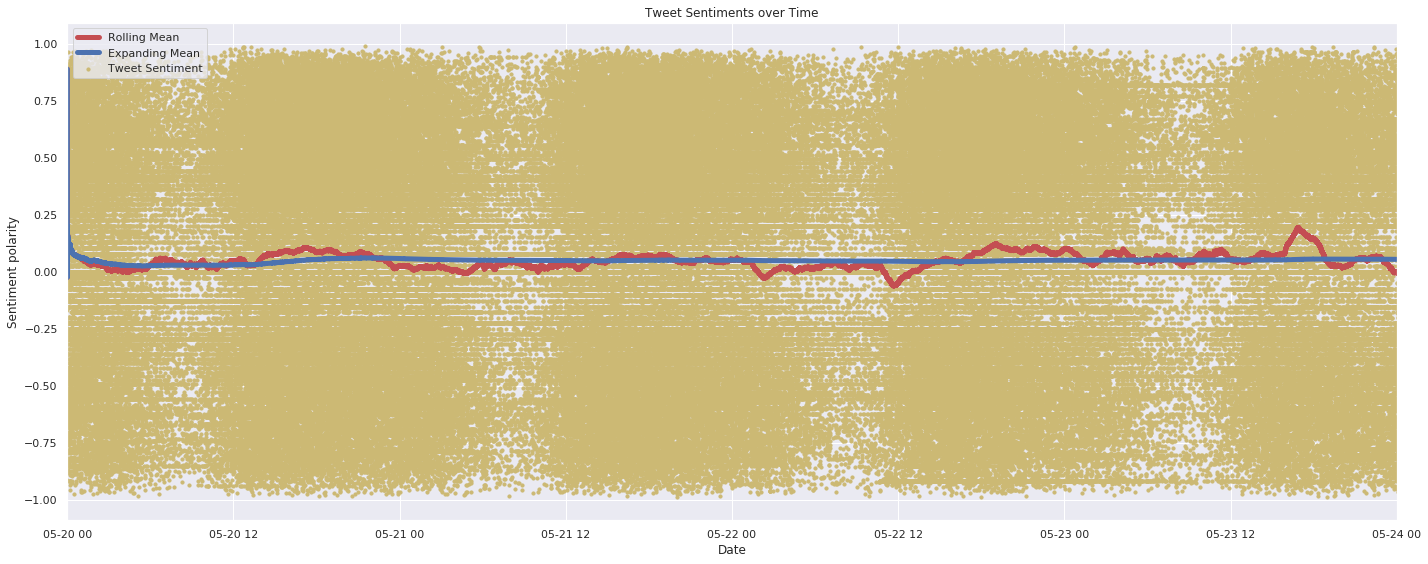

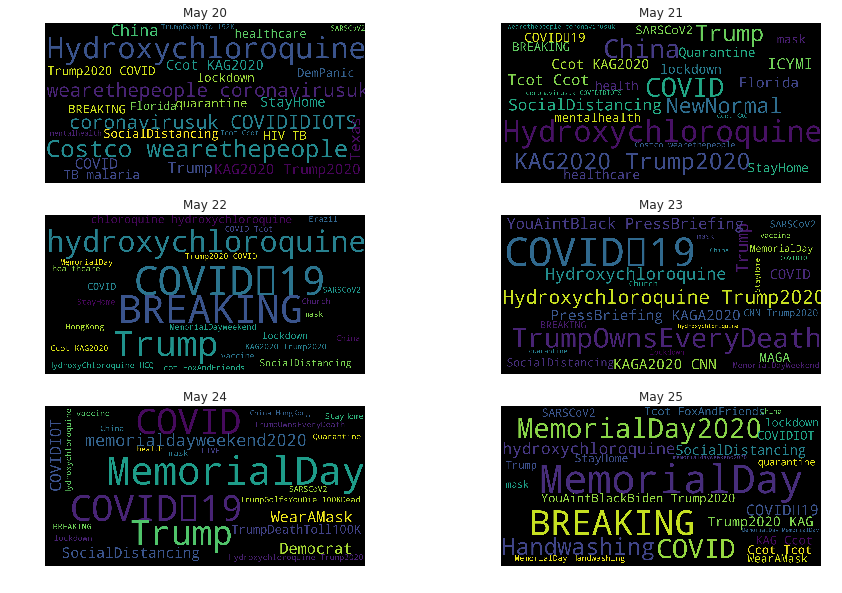

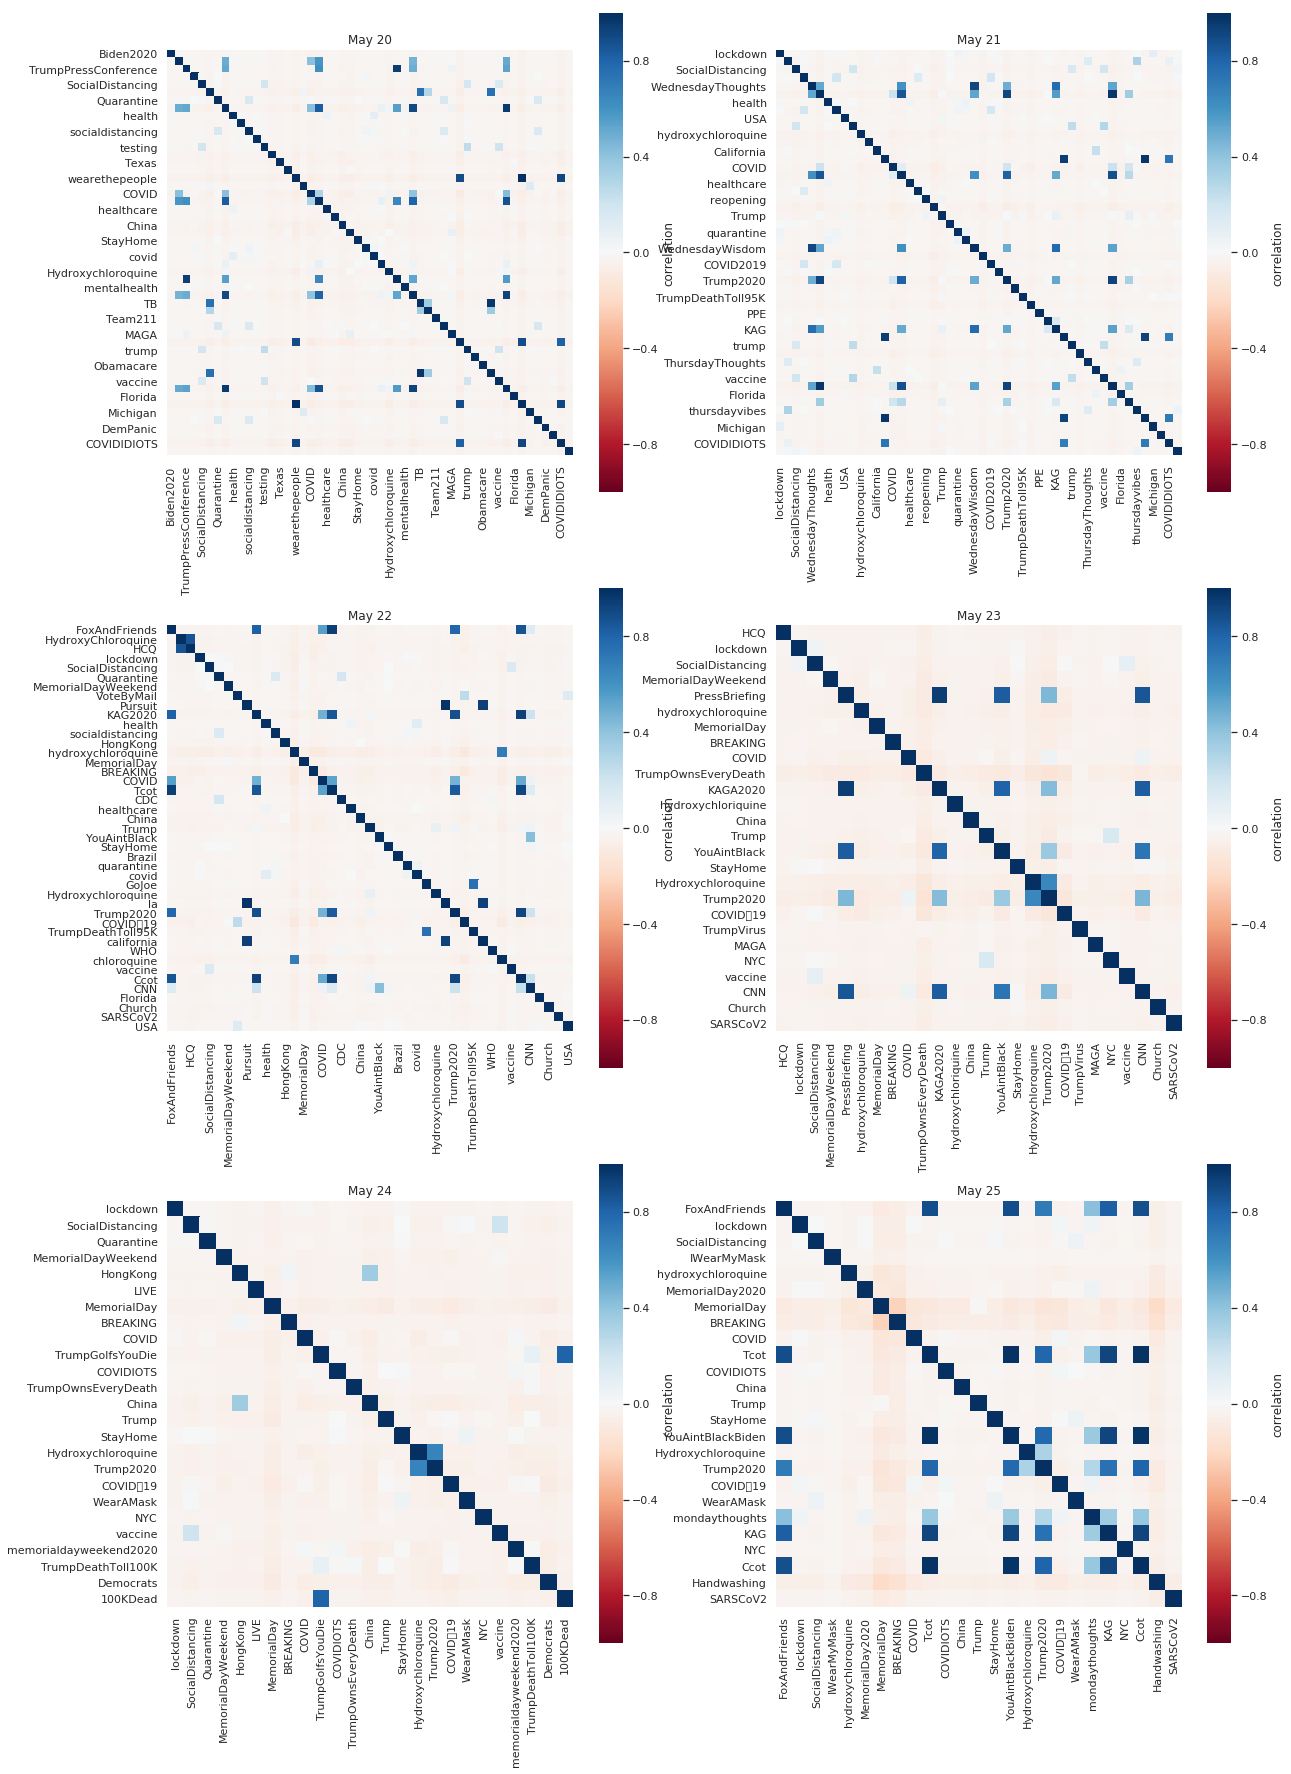

In [318]:
country = 'USA'
tf_count = 30
sample = 0.8
roll = '1H'

df_country = df_text[df_text.code == country]


# Term Frequency
sns.set(style="darkgrid")
counts_df = getTermFrequency(df_country, tf_count)
counts_df.columns = ['word', 'frequency']
fig, ax = plt.subplots(figsize = (8, 8))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)



# Hashtags of polar words
clouds = getPolarClouds(df_country, tf_count)

fig, axs = plt.subplots(2, 2, figsize = (15, 10))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(clouds.get('positive'))
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')

axs[0, 1].imshow(clouds.get('negative'))
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')

axs[1, 0].imshow(clouds.get('neutral'))
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')

axs[1, 1].imshow(clouds.get('all'))
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
plt.show()



# Sentiment scores daywise
df_country.groupby(['date', 'sentiment']).size().unstack().plot(kind='bar',figsize=(11, 5))



# Temporal sentiments
ot = getMovingAverages(df_country, sample, roll)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.scatter(ot['created_at'],ot['vader_score'], label='Tweet Sentiment', s = 10, color = 'y')
ax.plot(ot['created_at'],ot['rolling'], color ='r', label='Rolling Mean', linewidth = 5)
ax.plot(ot['created_at'],ot['expanding'], color='b', label='Expanding Mean', linewidth = 5)
ax.set_xlim([dt.date(2020,5,20),dt.date(2020,5,24)])
ax.set(title='Tweet Sentiments over Time', xlabel='Date', ylabel='Sentiment polarity')
ax.legend(loc='best')
fig.tight_layout()
plt.show()



# Clouds of hashtags
p = df_country.groupby(['date']).agg({'hashtags': flattenSeries}).reset_index()
displayWordcloud(p.hashtags, "Hashtags cloud", len(p), 25)



# Hashtag Correlations
p = df_country.groupby(['date']).agg({'hashtags': getHashtagCorr}).reset_index()
displayDailyCorr(p)

In [177]:
t = df_text[df_text.code == 'GBR']
t.created_at = pd.to_datetime(t.created_at)

# pd.to_datetime(t.iloc[0].created_at).strftime("%m-%d-%Y %H:%M:%S")

In [172]:
t[(t.created_at > '05-22-2020 22:00:00') & (t.created_at < '05-23-2020 04:00:00')]

,created_at,full_text,entities,date,vader_score,sentiment,code
1193561,2020-05-23 00:00:00+00:00,"RT @WHO: ""People with #diabetes are vulnerable...","{'hashtags': [{'text': 'diabetes', 'indices': ...",2020-05-23,-0.8176,negative,GBR
1193563,2020-05-22 23:59:59+00:00,@LeshieLoves Your dad should have been given t...,"{'hashtags': [{'text': 'PPE', 'indices': [49, ...",2020-05-22,-0.8511,negative,GBR
1193591,2020-05-22 23:59:52+00:00,"RT @WHO: ""As the world passes 5 million record...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.3612,neutral,GBR
1193601,2020-05-22 23:59:49+00:00,"RT @WHO: ""Maintaining people’s trust in the ab...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.8860,positive,GBR
1193605,2020-05-22 23:59:48+00:00,RT @RVAwonk: This should be illegal: Through i...,"{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,-0.2500,neutral,GBR
1193618,2020-05-22 23:59:46+00:00,"RT @WHO: ""When health systems are overwhelmed,...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.3612,neutral,GBR
1193630,2020-05-22 23:59:44+00:00,"RT @peterjukes: On a personal note, I was symp...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.0000,neutral,GBR
1193633,2020-05-22 23:59:44+00:00,"RT @WHO: ""A key part of this week’s landmark #...","{'hashtags': [{'text': 'WHA73', 'indices': [45...",2020-05-22,0.3612,neutral,GBR
1193640,2020-05-22 23:59:43+00:00,"RT @MEMEMac00965506: Please watch. If like me,...","{'hashtags': [], 'symbols': [], 'user_mentions...",2020-05-22,0.5719,positive,GBR
1193650,2020-05-22 23:59:39+00:00,"RT @WHO: ""As the world passes 5 million record...","{'hashtags': [{'text': 'COVID19', 'indices': [...",2020-05-22,0.3612,neutral,GBR


In [8]:
a = pd.read_csv(main_dir + 'data_full/' + '05-29-2020_full.csv')
a.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang
0,Sat May 30 00:00:02 +0000 2020,1.26652e+18,1.26652e+18,This 103-year-old centenarian grandmother from...,False,"[0, 202]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,False,en
1,Sat May 30 00:00:02 +0000 2020,1.26652e+18,1.26652e+18,Coronavirus live update:\n\nTotal cases: Total...,False,"[0, 179]","{'hashtags': [{'text': 'CoronaVirus', 'indices...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,NaN,en
2,Sat May 30 00:00:02 +0000 2020,1.26652e+18,1.26652e+18,@TownPunnetts Further waves were always inevit...,False,"[14, 280]","{'hashtags': [{'text': 'covid19', 'indices': [...","<a href=""http://twitter.com/#!/download/ipad"" ...",1.266494e+18,1.266494e+18,...,NaN,NaN,NaN,False,0,0,False,False,NaN,en
3,Sat May 30 00:00:01 +0000 2020,1.26652e+18,1.26652e+18,"Explore #COVID19 projections for #Mexico, incl...",False,"[0, 203]","{'hashtags': [{'text': 'COVID19', 'indices': [...","<a href=""https://prod1.sprinklr.com"" rel=""nofo...",NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,False,en
4,Sat May 30 00:00:01 +0000 2020,1.26652e+18,1.26652e+18,New COVID-19 Data at 2020-05-29 08:00:00 pm ED...,False,"[0, 69]","{'hashtags': [{'text': 'Coronavirus', 'indices...","<a href=""https://kojospace.com/"" rel=""nofollow...",NaN,NaN,...,NaN,NaN,NaN,False,0,0,False,False,False,en


In [13]:
int(a.iloc[34].id)

1266519692711247872

In [46]:
n = 10
team1 = sorted(list(map(int, '3 6 7 5 3 5 6 2 9 1'.split())))
team2 = sorted(list(map(int, '2 7 0 9 3 6 0 6 2 6'.split())))
print(team1)
print(team2)

print()

combined = sorted(team1 + team2)
dp = [[0, 0]]
team1_ind = 0
team2_ind = 0
# count = 0
i = 0

for i in range(2*n):
    print(i, team1_ind, team2_ind)
    if combined[i] == team1[team1_ind]:
        t = [min(dp[-1][0]+1, dp[-1][1]), dp[-1][1]]
        team1_ind += 1 
        
    else:
        t = [dp[-1][0],dp[-1][1]+1]
        team2_ind += 1
    dp.append(t) 
    if (team1_ind == n or team2_ind == n):
        break
    
# while i < len(combined) and team1_ind < len(team1):
#     print(combined, team1[team1_ind], i)

#     if combined[i] == team1[team1_ind]:
#         if(i == 0):
#             del(combined[i])
#         else:
#             del(combined[i-1:i+1])
#             count += 1

#             i -= 1
#         team1_ind += 1
#     else:
#         i += 1

print(dp[-1][0])


[1, 2, 3, 3, 5, 5, 6, 6, 7, 9]
[0, 0, 2, 2, 3, 6, 6, 6, 7, 9]

0 0 0
1 0 1
2 0 2
3 1 2
4 2 2
5 2 3
6 2 4
7 3 4
8 4 4
9 4 5
10 5 5
11 6 5
12 7 5
13 8 5
14 8 6
15 8 7
16 8 8
17 9 8
18 9 9
7


In [48]:
''' Read input from STDIN. Print your output to STDOUT '''
    #Use input() to read input from STDIN and use print to write your output to STDOUT

def main():
    # Write code here 
    t = int(input())
    for c in range(t):
        
        n = int(input())
        team1 = list(map(int, input().split()))
        team2 = list(map(int, input().split()))

        combined = team1 + team2
        combined.sort()
        team1.sort()
        team2.sort()

        dp = [[0, 0]]
        team1_ind = 0
        team2_ind = 0
        i = 0

        for i in range(2*n):
            print(i, team1_ind, team2_ind)
            if combined[i] == team1[team1_ind]:
                t = [min(dp[-1][0]+1, dp[-1][1]), dp[-1][1]]
                team1_ind += 1 
                
            else:
                t = [dp[-1][0],dp[-1][1]+1]
                team2_ind += 1
            dp.append(t) 
            if (team1_ind == n or team2_ind == n):
                break

        print(dp[-1][0])


main()



1
10
3 6 7 5 3 5 6 2 9 1
2 7 0 9 3 6 0 6 2 6 
0 0 0
1 0 1
2 0 2
3 1 2
4 2 2
5 2 3
6 2 4
7 3 4
8 4 4
9 4 5
10 5 5
11 6 5
12 7 5
13 8 5
14 8 6
15 8 7
16 8 8
17 9 8
18 9 9
7


In [42]:
x = [[5,6]]
x[-1] + [2,6]

[5, 6, 2, 6]